In [1]:
from texture.networks.dilation_net import dilation_net
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
entry_3x3_1 (Conv2D)            (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
entry_3x3_2 (Conv2D)            (None, 224, 224, 128 36992       entry_3x3_1[0][0]                
__________________________________________________________________________________________________
block_32_1x1_1 (Conv2D)         (None, 224, 224, 32) 4128        entry_3x3_2[0][0]                
__________________________________________________________________________________________________
block_32_1

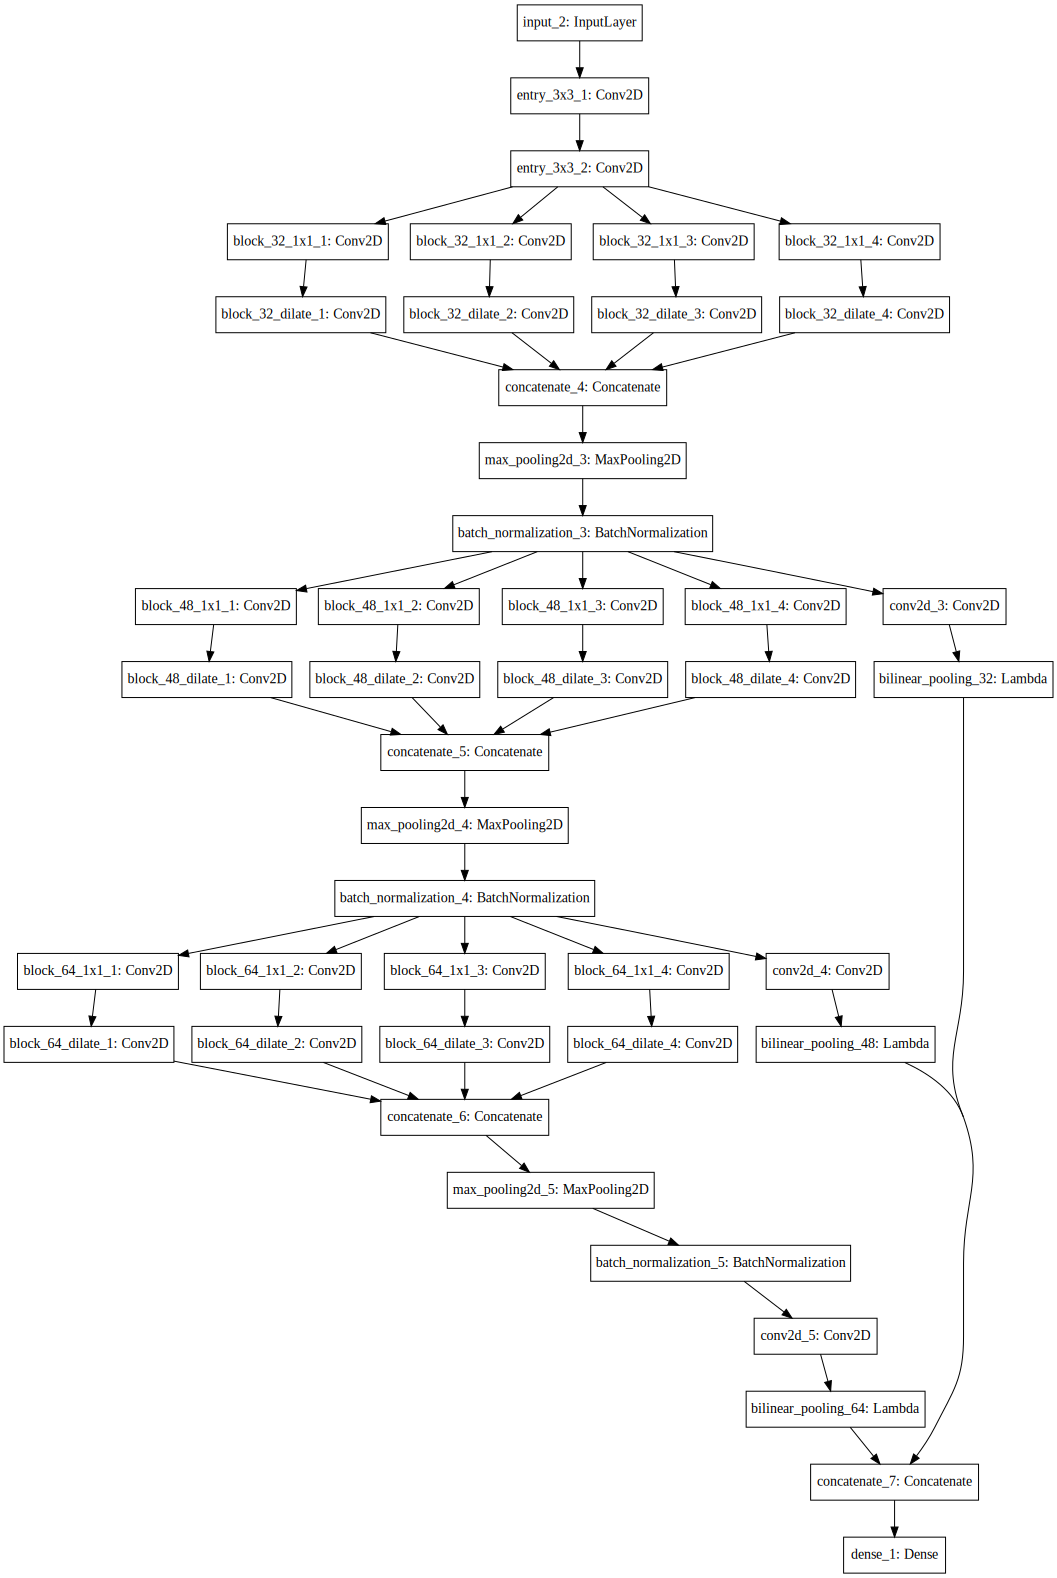

In [3]:
dnet = dilation_net(47, (224,224,3))#, entry_conv=False)

dnet.summary()

SVG(model_to_dot(dnet).create(prog='dot', format='svg'))